Name:  Vincent Nguyen 
<br>
Class: CS 4395.001 
<br>
Date:  04 April 2023
<br>
NetID: VTN180000

In [454]:
import pandas as panda
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as train_test
import numpy as np
import seaborn 
from sklearn import datasets
from sklearn.naive_bayes import MultinomialNB
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

In [455]:
# Read in csv file
dataframes = panda.read_csv('/kaggle/input/amazon-reviews-dataset/cleaned_reviews.csv', header=0, usecols=[0,1], encoding='ISO-8859-1')

# Replace negative, positive, neutral with numeric values in the sentiments column
dataframes.sentiments.replace('negative', 1, inplace=True)
dataframes.sentiments.replace('positive', 3, inplace=True)
dataframes.sentiments.replace('neutral', 2, inplace=True)

# Use .head to make sure the negative, positive, and neutral sentiments has correct numeric values
dataframes.head()

,sentiments,cleaned_review
0,3,i wish would have gotten one earlier love it a...
1,2,i ve learned this lesson again open the packag...
2,2,it is so slow and lags find better option
3,2,roller ball stopped working within months of m...
4,2,i like the color and size but it few days out ...


In [456]:
# Get features and target. We will only use the review and sentiment column.
# We will not use the rest of the columns. 
feature = dataframes.cleaned_review  
target = dataframes.sentiments 

# Get sentiment column
dataframe_target = panda.DataFrame(target, columns=['sentiments'])

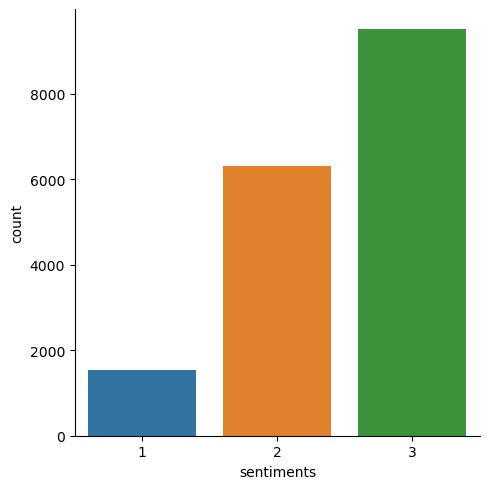

In [457]:
# Create graph to show distribution of target class
seaborn.catplot(x="sentiments", kind='count', data=dataframe_target)

The graph shows the negative, neutral, and positive distribution of the target class. Negative has the value of 1, neutral has the value of 2, and positive has the value of 3 in the graph. It looks like most of the sentiments are positive. So, there are lots of positive reviews. The least amount of sentiments are the negative sentiments. This model should be able to predict the positive, negative, and neutral sentiments of the reviews.

In [458]:
# Split test and train. We are testing 20% of the data and training with 80% of the data
feature_train, feature_test, target_train, target_test = train_test(feature, target, test_size=0.2, train_size=0.8, random_state=1234)

In [459]:
# Remove stopwords
text_stopword = set(stopwords.words('english'))
vectorize_text = TfidfVectorizer(stop_words=text_stopword)

# Vectorize the data of train and test
# Use .astype('U') because we get a ValueError: np.nan is an invalid document
feature_train = vectorize_text.fit_transform(feature_train.astype('U')) 
feature_test = vectorize_text.transform(feature_test.astype('U'))

# Naive Bayes

In [460]:
# First, we will do naive bayes multinomial
nb_multinomial = MultinomialNB()
nb_multinomial.fit(feature_train, target_train)

MultinomialNB()

In [461]:
# Get predictions for the test data
prediction = nb_multinomial.predict(feature_test)

# Confusion matrix 
confusion_matrix(target_test, prediction)

array([[   2,  233,   70],
       [   0,  626,  615],
       [   0,  124, 1798]])

In [462]:
# Get classification report for naive bayes multinomial
print(classification_report(target_test, prediction))

              precision    recall  f1-score   support

           1       1.00      0.01      0.01       305
           2       0.64      0.50      0.56      1241
           3       0.72      0.94      0.82      1922

    accuracy                           0.70      3468
   macro avg       0.79      0.48      0.46      3468
weighted avg       0.72      0.70      0.66      3468



In [463]:
# See the multinomial predictions that are classified wrong
target_test[target_test != prediction]

496      3
9100     3
6656     3
11270    1
16086    2
        ..
1813     1
9535     1
16092    2
6178     2
4960     3
Name: sentiments, Length: 1042, dtype: int64

Next we will do naive bayes binomial

In [464]:
# Remove stopwords
vectorize_binary = TfidfVectorizer(stop_words=text_stopword, binary=True)

# Vectorize the features
feature = vectorize_binary.fit_transform(dataframes.cleaned_review.astype('U'))

# Split test and train. We are testing 20% of the data and training with 80% of the data
feature_train, feature_test, target_train, target_test = train_test(feature, target, test_size=0.2, \
                                                                    train_size=0.8, random_state=1234)
nb_bernoulli = BernoulliNB()
nb_bernoulli.fit(feature_train, target_train)

# Get predictions for the test data binomial
predictions = nb_bernoulli.predict(feature_test)

# Confusion matrix 
confusion_matrix(target_test, predictions)

array([[ 101,  171,   33],
       [  78,  973,  190],
       [ 113,  422, 1387]])

In [465]:
# Get classification report for naive bayes binomial
print(classification_report(target_test, predictions))

              precision    recall  f1-score   support

           1       0.35      0.33      0.34       305
           2       0.62      0.78      0.69      1241
           3       0.86      0.72      0.79      1922

    accuracy                           0.71      3468
   macro avg       0.61      0.61      0.61      3468
weighted avg       0.73      0.71      0.71      3468



In [466]:
# See the binomial predictions that are classified wrong
target_test[target_test != predictions]

16717    3
496      3
14399    3
9100     3
6656     3
        ..
6178     2
14740    2
752      3
6737     2
4960     3
Name: sentiments, Length: 1007, dtype: int64

**Analysis:**

Looking at the naive bayes multinomial and binomial classification reports, it looks like the naive bayes binomial did better than the multinomial. Some of the multinomial precision scores is better than the binomial precision scores. However, most of the binomial recall and f1 scores are better than the binomial. Furthermore, the binomial accuracy, macro, and weighted averages in the classification report have higher scores than the multinomial scores.

# Logistic Regression
<br>
We will do logitic regression via pipes in this section.

In [467]:
# Get features and target.
feature = dataframes.cleaned_review  
target = dataframes.sentiments 

# Split into test and train. We will test 20% of the data, and train from 80% of the data
feature_train, feature_test, target_train, target_test = train_test(feature, target, test_size=0.2, \
                                                                    train_size=0.8, random_state=1234)

# We use pipeline for logistic regression
# We increase max_iter or else there will be a ConvergenceWarning
vectorize_text = TfidfVectorizer(binary=True)
log_regression = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=2000)
pipes_pipeline = Pipeline([('Tfidf', vectorize_text),('Logistic', log_regression)])
pipes_pipeline.fit(feature_train.astype('U'), target_train)

Pipeline(steps=[('Tfidf', TfidfVectorizer(binary=True)),
                ('Logistic',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [468]:
# Get predictions and probability from the pipeline
prediction_log = pipes_pipeline.predict(feature_test)
probability = pipes_pipeline.predict_proba(feature_test)

# Confusion matrix
print(confusion_matrix(target_test, prediction_log))

# Print out logistic loss results
print('Logistic Loss: ', log_loss(target_test, probability))

[[ 243   50   12]
 [ 181  941  119]
 [  52  217 1653]]
Logistic Loss:  0.4703408664360614


In [469]:
# Print out classification report
print(classification_report(target_test, prediction_log))

              precision    recall  f1-score   support

           1       0.51      0.80      0.62       305
           2       0.78      0.76      0.77      1241
           3       0.93      0.86      0.89      1922

    accuracy                           0.82      3468
   macro avg       0.74      0.81      0.76      3468
weighted avg       0.84      0.82      0.82      3468



**Analysis:**

If we compare the naive bayes and logistic regression, the logistic regression has higher scores in the recall and f1 scores area. However, naive bayes has two scores in the precision score area that are higher than the two scores in the precision area of the logistic regression. The logistic loss was calculated to be about 0.47034. In my opinion, this is a high log loss since the log loss is almost 0.5. The accuracy was calculated to be 0.82, which I see as a high score as well.


# Neural Networks

In [470]:
# Remove stopwords
vectorize_text = TfidfVectorizer(stop_words=text_stopword, binary=True)

# Get feature and target
review = dataframes.cleaned_review
feature = vectorize_text.fit_transform(review.astype('U')) 
target = dataframes.sentiments 

# Here we test and train data. We test 20% of the data, and we train 80% of the data
feature_train, feature_test, target_train, target_test = train_test(feature, target, test_size=0.2, \
                                                                    train_size=0.8, random_state=1234)

# Set up mlp classifier
# Increase max_iter so we do not have a ConvergenceWarning
multi_layer = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(14, 2), random_state=1, \
                            max_iter=2000)
multi_layer.fit(feature_train, target_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(14, 2), max_iter=2000,
              random_state=1, solver='lbfgs')

In [471]:
# Get predictions
prediction_mlp = multi_layer.predict(feature_test)

# Print out classification report
print(classification_report(target_test, prediction_mlp))

              precision    recall  f1-score   support

           1       0.72      0.62      0.67       305
           2       0.78      0.83      0.80      1241
           3       0.91      0.89      0.90      1922

    accuracy                           0.84      3468
   macro avg       0.80      0.78      0.79      3468
weighted avg       0.85      0.84      0.84      3468



**Analysis:**

The f1 scores and accuracy of the neural network are higher than the f1 scores and accuracy of the naive bayes and the logistic regression. Most of the precision and recall in the neural network are higher than the precision and recall of the naive bayes and logistic regression. As a result, I would say that the neural network is better to use than the naive bayes and logistic regression.